# 0.0 IMPORTS

In [164]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

import inflection

from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from matplotlib import pyplot        as plt
from sklearn    import cluster       as c
from sklearn    import preprocessing as pp
from sklearn    import metrics       as m
from plotly     import express       as px

## 0.1 Helper Functions

In [27]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [28]:
# Load dataset
df_raw = pd.read_csv( '/home/jeffsmedines/repos/loyalty_program/data/raw/Ecommerce.csv', encoding='unicode_escape' )

# Drop NA Column
df_raw = df_raw.drop( columns=['Unnamed: 8'] )

# 1.0 DATA DESCRIPTION

In [29]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [30]:
columns = df1.columns
new_columns = [inflection.underscore( x ) for x in columns]
df1.columns = new_columns

## 1.2 Data Dimensions

In [31]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [32]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA's

In [33]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA's

In [34]:
# Remove NA's
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( f'Removed data: {1 - (df1.shape[0] / df_raw.shape[0]):.2%}' )

Removed data: 24.93%


In [35]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Data Types

In [36]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# Customer ID
df1['customer_id'] = df1['customer_id'].astype( int )

In [37]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [38]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [39]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
ds = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ds.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ds

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'> 1.7.2 Numerical Attributes - Investigating </font>

1. Quantity negativa. (talvez seja devolução)
2. Preço unitário igual a zero. (conferir se foi uma promoção)

### 1.7.2 Categorical Attributes

In [40]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [41]:
# Invoice number
len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates())

3654

In [67]:
# Stock code
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code'].head()

0     85123A
2     84406B
3     84029G
4     84029E
45      POST
Name: stock_code, dtype: object

In [69]:
# Stock code
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [131]:
cat_attributes[cat_attributes['stock_code'] == 'C2'].count()

invoice_no     134
stock_code     134
description    134
country        134
dtype: int64

# 2.0 DATA FILTERING

In [155]:
df2 = df1.copy()

## 2.1 Numerical Attributes Filtering

In [156]:
# Unit price < 0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# Stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'C2', 'DOT', 'CRUK'] )]

# Quantity
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchase = df2.loc[df2['quantity'] > 0, :].copy()

In [157]:
df2_purchase.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

# 3.0 FEATURE ENGINEERING

In [158]:
df3 = df2.copy()

## 3.1 Feature Creation

In [159]:
df_ref = df3.drop( columns=['invoice_no', 'stock_code',
                            'description', 'quantity',
                            'invoice_date', 'unit_price',
                            'country'], axis=1 ).drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [160]:
# Gross Revenue
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop( columns=['invoice_date'], axis=1 )
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2_purchase[['invoice_no', 'customer_id']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# Avg ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

# Returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'returns'} )
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0



In [161]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [167]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [ ]:
# # Gross Revenue
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary
# df_monetary = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
# df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# # Recency
# df_recency = df3[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
# df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency.drop( columns=['invoice_date'], axis=1 )
# df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# # Frequency
# df_freq = df3[['invoice_no', 'customer_id']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
# df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# # Avg ticket
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )

# df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

# 4.0 EXPLORATORY DATA ANALYSIS

In [163]:
df4 = df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [169]:
df5 = df4.copy()

In [170]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [171]:
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )

In [172]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667


# 6.0 FEATURE SELECTION

In [173]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [174]:
X = df6.drop( columns=['customer_id'] )

## 7.1 Within-Cluster Sum of Square (WSS)

In [175]:
clusters = [2, 3, 4, 5, 6, 7]

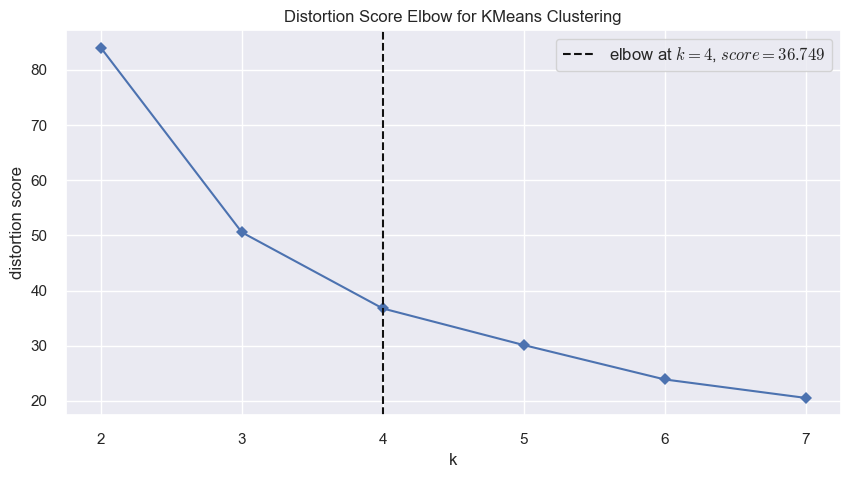

In [176]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Score

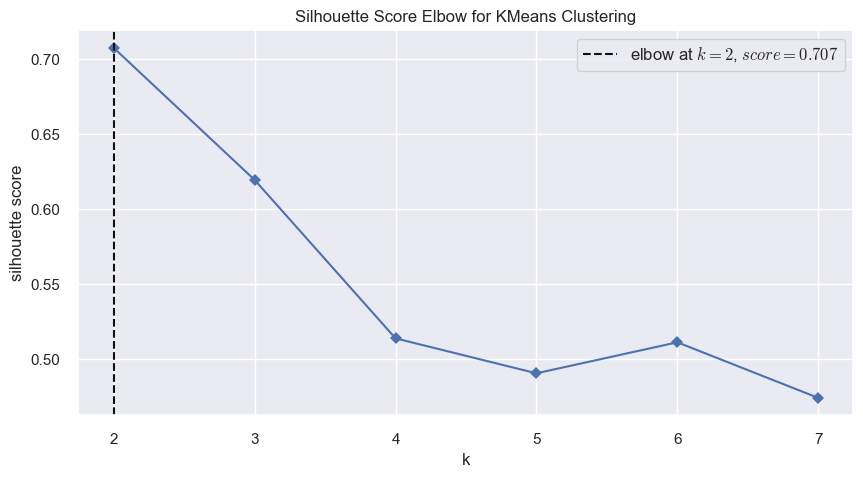

In [178]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), metric='silhouette', k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.3 Silhouette Analysis

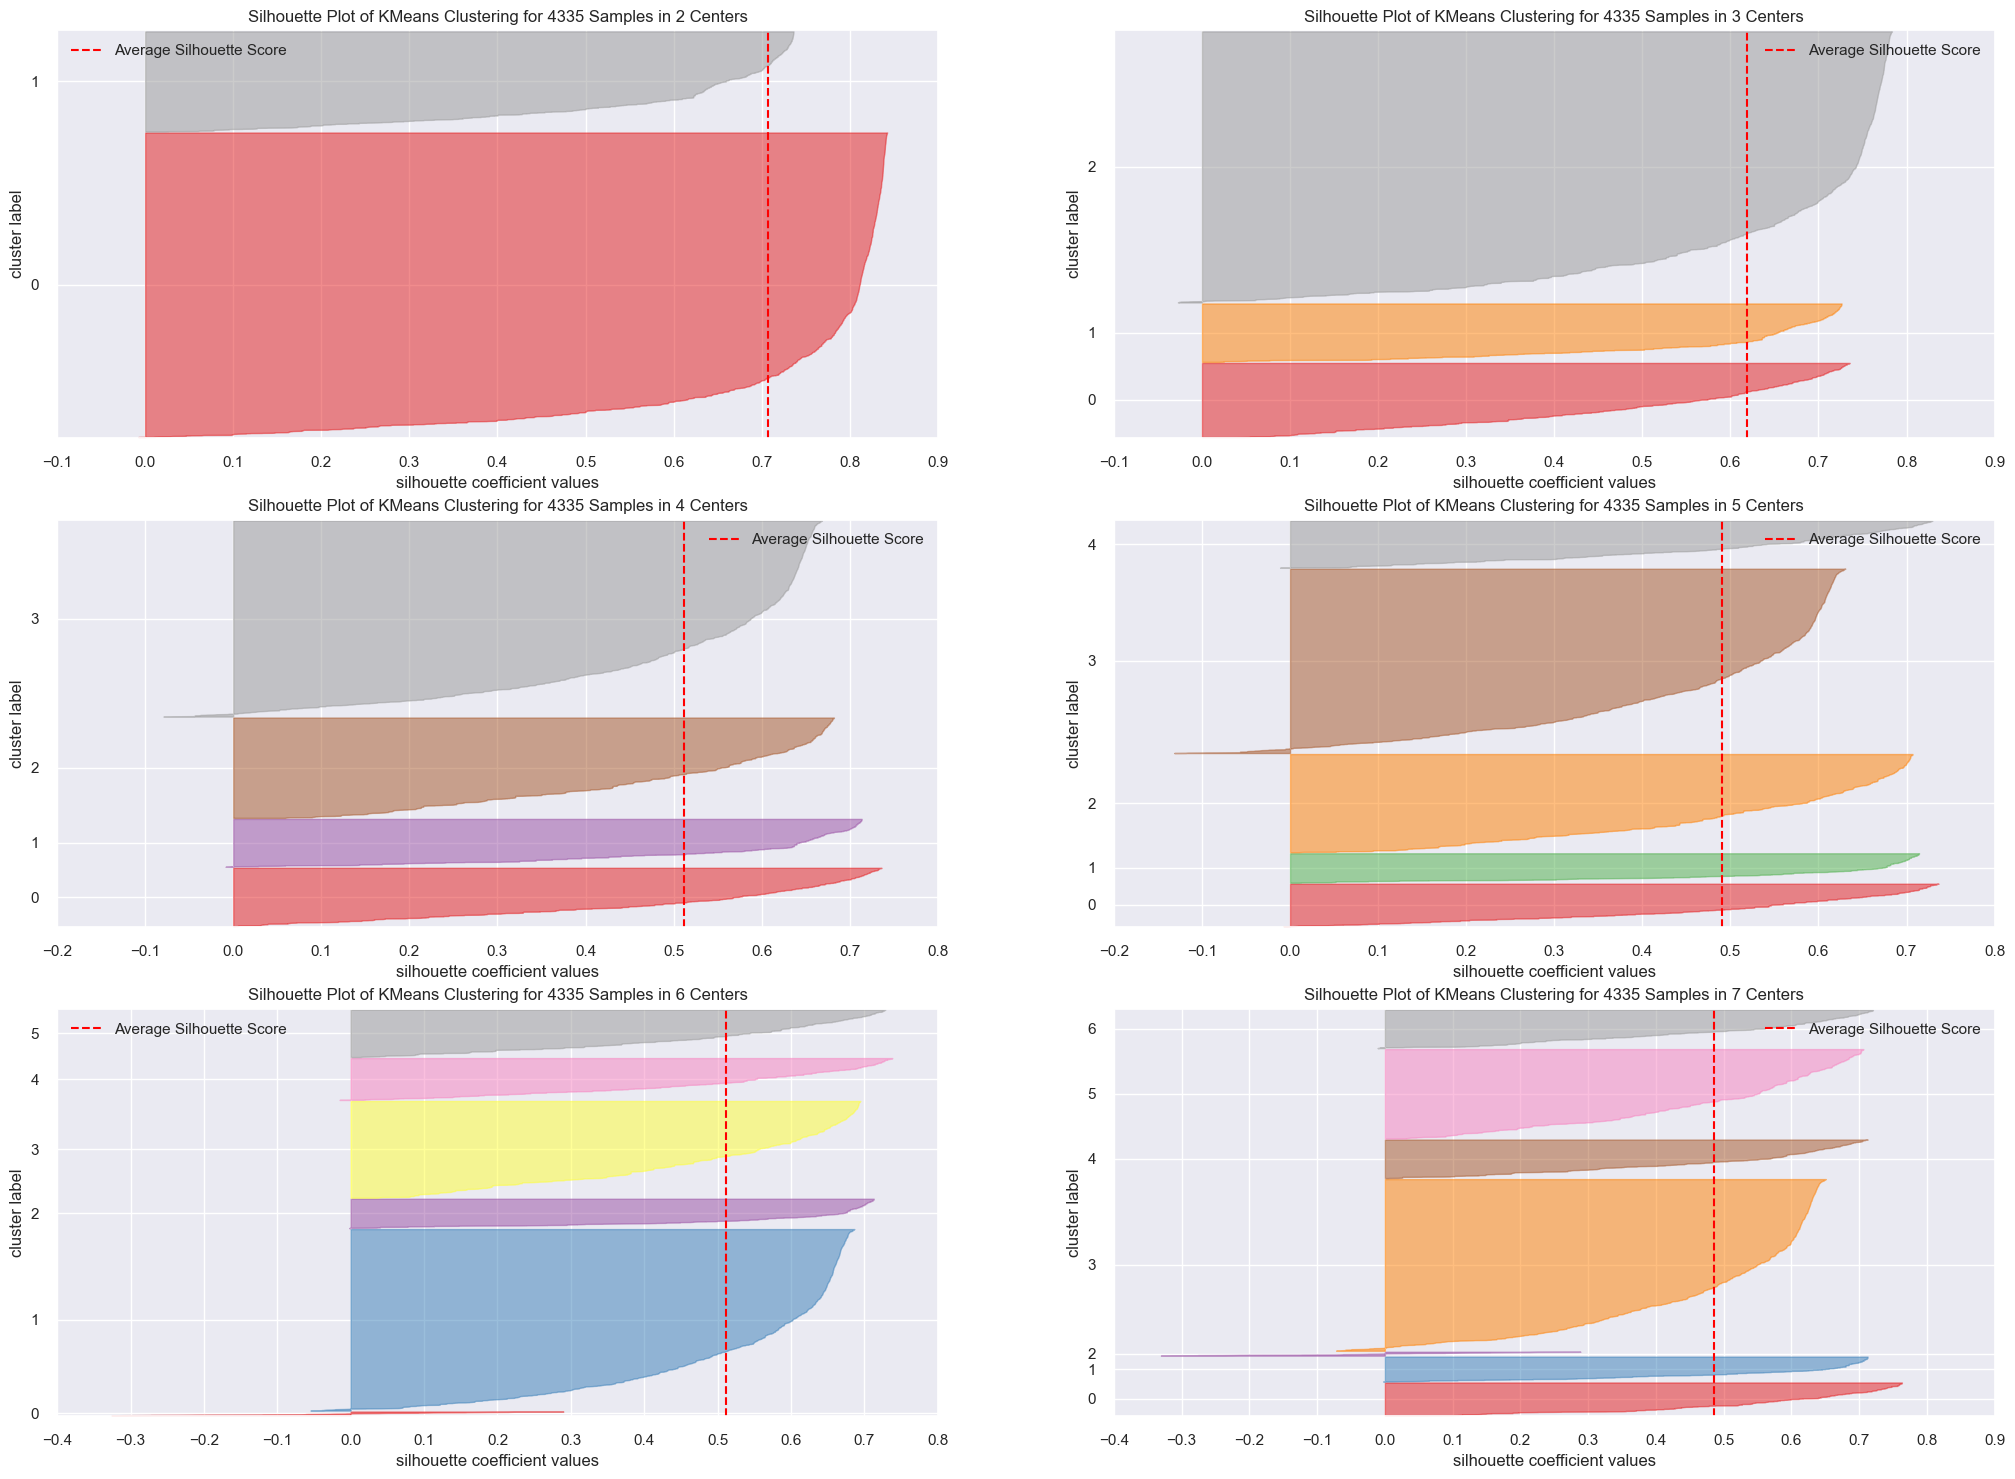

In [179]:
fig, ax = plt.subplots( 3, 2, figsize=( 25, 18 ) )


for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [188]:
# Model Definition
k = 6
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# Model Training
kmeans.fit( X.values )

# Clustering
labels = kmeans.labels_

In [189]:
# WSS
print( f'WSS value: {kmeans.inertia_:.2f}' )

# SS
print( f'SS value: {m.silhouette_score( X, labels ):.4f}' )

WSS value: 23.91
SS value: 0.5111


# 9.0 CLUSTER ANALYSIS

In [190]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222,2
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556,3
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444,1
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,3
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667,2


## 9.1 Visualization Inspection

In [191]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
# fig.show()

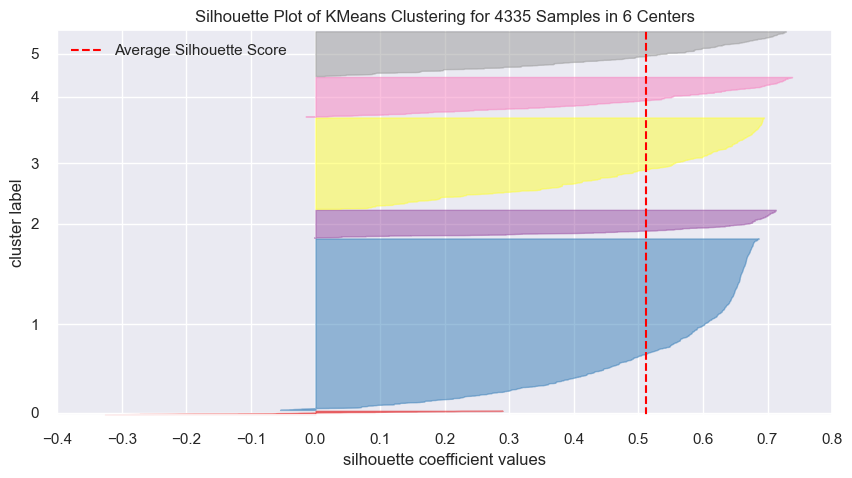

In [192]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick' )
visualizer.fit( X.values )
visualizer.finalize()

## 9.2 2D Plot

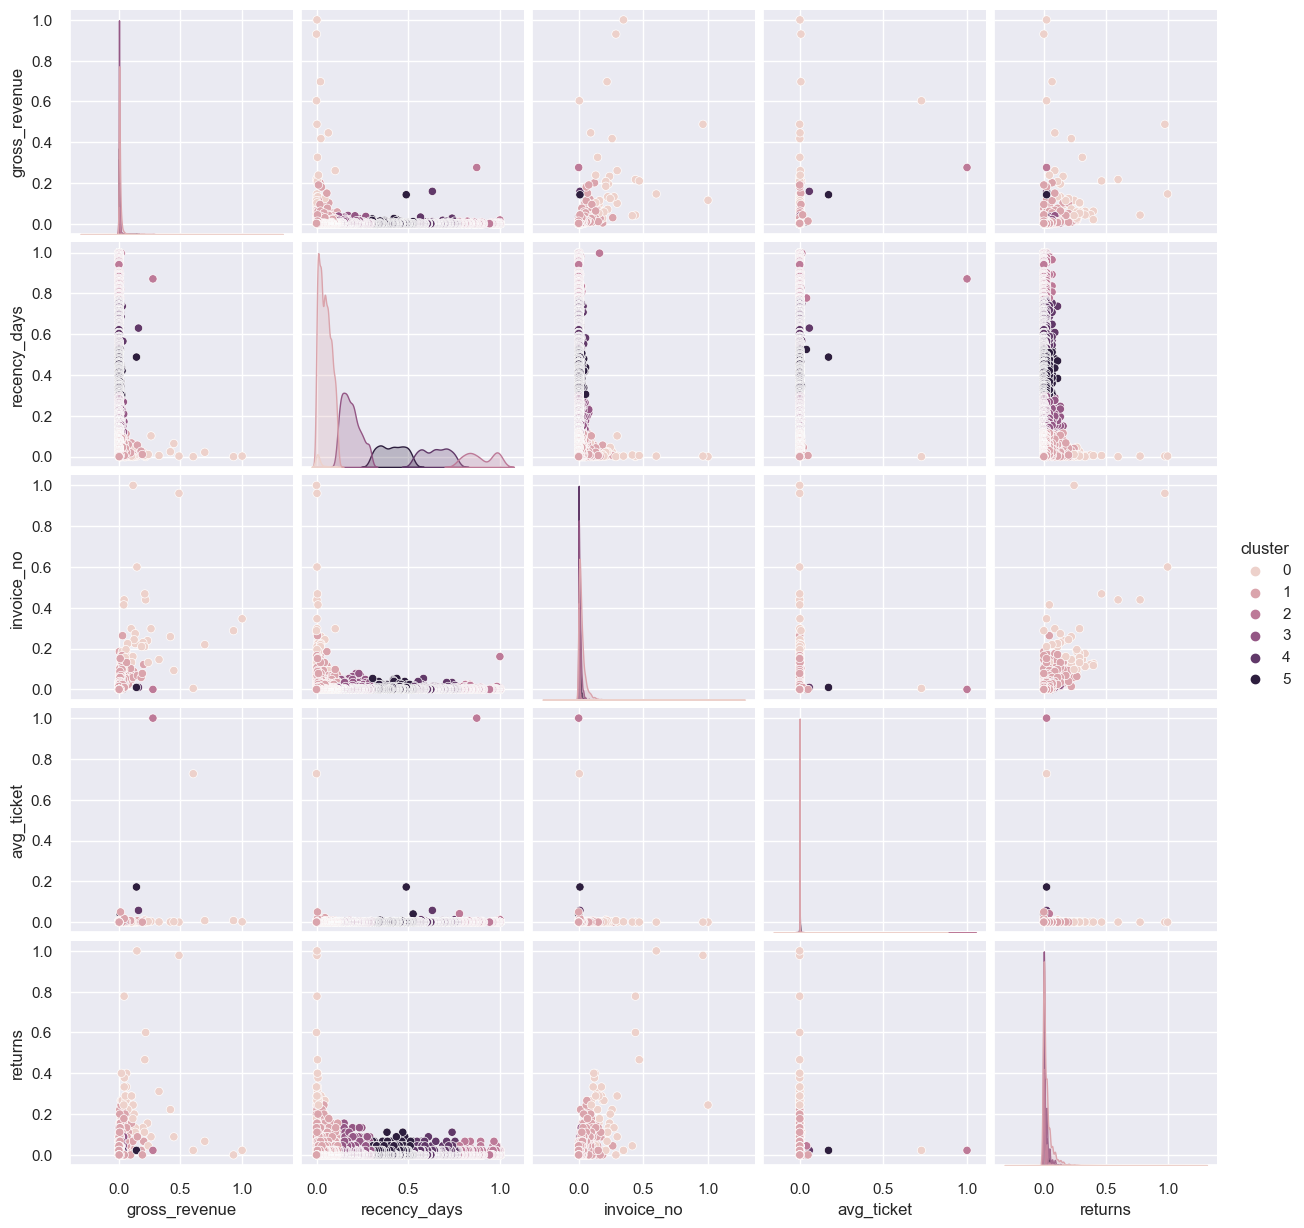

In [193]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3 UMAP - t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

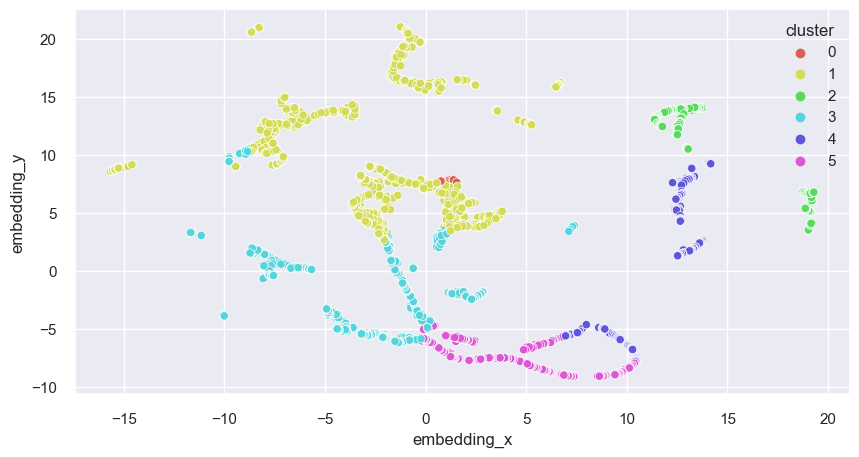

In [194]:
reducer = umap.UMAP( n_neighbors=20, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ), data=df_viz)

## 9.2 Cluster Profile

In [195]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg gross revenue 
df_avg_gross = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross, how='inner', on='cluster' )

# Avg recency days
df_avg_recency = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on='cluster' )

# Avg invoice_no
df_avg_invoice = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice, how='inner', on='cluster' )

# Avg ticket by cluster
df_avg_ticket_cluster = df9[['cluster', 'avg_ticket']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket_cluster, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,43,0.991926,0.199137,0.012220,0.250255,0.018358
1,1,1962,45.259516,0.008055,0.046504,0.022826,0.000356
2,2,318,7.335640,0.002264,0.890249,0.001641,0.003715
3,3,1046,24.129181,0.003699,0.186442,0.008236,0.000350
4,4,454,10.472895,0.002085,0.645144,0.002407,0.000572
5,5,512,11.810842,0.002788,0.408486,0.005659,0.000789


 ### Cluster 1 (Insiders)
    - Representam 0,13% da base.
    - Gastaram $182181,98 na média.
    - Compraram a última vez a 7 dias na média.
    - Compraram 89 itens na média.
    
    
    
### Cluster 2 
    - Representam 99,15% da base.
    - Gastaram em média $1372,57.
    - Compraram a última vez 92 dias atrás na média.
    - Compraram 4 itens na média.



    
### Cluster 3
    - Representam 0,70% da base.
    - Gastaram $40543,51 na média.
    - Compraram a última vez 13 dias atrás na média.
    - Compraram 53 unidades na média.

# 10.0 DEPLOY TO PRODUCTION